Lecture 12 will cover how to tie the GUI-widgets to the application logic. It will cover the Model-View-Controller (MVC) design concept for GUI.

Reference
 * PyQt and Qt documentation

First a bit of standard stuff needed to work with Qt

In [1]:
from PyQt5.QtCore import *
from PyQt5.QtGui import *
from PyQt5.QtWidgets import *
import sys

In [2]:
qt_app = QApplication(sys.argv)

# Model / State

It is important to think of the *state* of an interactive piece of software.
In sequential scripts, it is easy to keep track of the state, as the order of events are all predetermined, but this is not the case in interactive applications (whether or not they are graphical).

For example, the minimum state of a chess game would be:
* Whose players turn it is.
* The position of all pieces left on the board.

but a nicely presented game might need to store more
* All the moves so far, in order, for each player
* The pieces taken by each player.

The user interface renders the information from the state. The user interacts with the user interface which sends signals back to the state to modify it.

## Mismatching UI and application state

A common mistake is to let the presented UI not match the actual program state.
Lets take the example of a simple painting application, where the state must at least include:
* The drawing surface (size, pixel values, etc.)
* The selected tool

When a tool is selected, it's commonly represented as a pressed down button.
When selecting a new tool, the previous tool button should be unpressed.
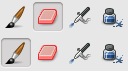
Well, that's not to bad. We could even just unpress all the buttons before repressing the new one to be sure.
But, then, later on, we learn about the undo-operation and now there is a real risk of messing this up unless we are making real sure that our growing application changes every thing thing it needs to on every possible action.

It's therefore not uncommon to see poorly written applications where you need to manually refresh a window, or "wiggle" the window edge around to force a window redraw event, or simply close and reopen a window in order for the content to be updated. In real-time games and such, this rarely happens, as games typically redraw everything as many times per second as they can, with little regard for battery life.

The challenge is with practical GUI-widget applications, we want to do as little as possible in order to make the program snappy with minimum system load while still always being sure that the current state of the program is always shown.

In order to ensure we don't have such bugs in when developing a large complex software, we need have a strategy! One such strategy is the "Model-View-Controller" design, which allows us to systematically approach interactive software.

# Signals

Last lecture we looked (briefly) at procedures for placing widgets. I hope you all agree that it is fairly straight forward to construct these, and now the more difficult task of having all the buttons interact and actually do something.
One can read more about this on:
https://www.tutorialspoint.com/pyqt/pyqt_signals_and_slots.htm

In it's simplest form, we have a *callback function*

In [3]:
def some_func():
    print("some function has been called!")

def some_other_func():
    print("some other function has been called!")

qt_app = QApplication.instance()
button = QPushButton("Call some function")

button.clicked.connect(some_func)
#         ^               ^
#       signal           slot

button.clicked.connect(some_other_func) # We can connect multiple slots to a signal.

button.show()
qt_app.exec_()

some function has been called!
some other function has been called!


0

Whenever the button is clicked, Qt finds out which button, and emits the signal for that button, like this:

In [4]:
button.clicked.emit()

some function has been called!
some other function has been called!


Signals can be emitted in other ways, for example using the `QTimer`. We can also create our own signals and use them outside of the graphical components, and emit them as we want;

In [5]:
class MyCounter(QObject): # QObject is necessary for signals
    my_signal = pyqtSignal(int)

    def __init__(self, initial_value):
        super().__init__()
        self.count = initial_value
        
    def increment(self):
        self.count += 1
        self.my_signal.emit(self.count)

In [6]:
c = MyCounter(42)
c.my_signal.connect(lambda x: print(f"Counter is now at {x}"))

In [7]:
c.increment()

Counter is now at 43


# Model View Controller (MVC)

From wikipedia:

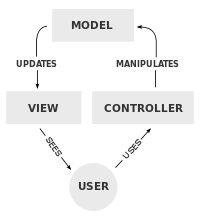

* A controller can send commands to the model to update the model's state (e.g., editing a document). It can also send commands to its associated view to change the view's *presentation* of the model (e.g., by scrolling through a document).
* A model notifies its associated views and controllers when there has been a change in its state. This notification allows the views to produce updated output, and the controllers to change the available set of commands. In some cases an MVC implementation might instead be "passive," so that other components must poll the model for updates rather than being notified.
* A view either gets information via the signal, or requests information from the model (after being triggered by a signal) that it uses to generate an output representation to the user.

The model is presicely that of the *state* described earlier.

The controller is typically part of the *view*, e.g. selecting an object represented by some icon in the *view*.

**Note** It is important to respect the one-way flow of information here; the view should be *passive*, only ever update itself if informed by a model to do so. The model contains the logic, and knows when values have changed.
Only changes that only affect the representation of the model may be directly handled in the view (e.g. switching from portrait to landscape mode when you turn your phone while using an app).

## QStringListModel and QStringListView

A simple example is that of predefined QStringListModel and QStringListView. The QStringListView incorporates the role of the Controller as well (as expected).

First, lets try the normal list widgets to see the problem

In [22]:
qt_app = QApplication.instance()

data = ["one", "two", "three", "four", "five"]

combobox = QComboBox()
combobox.addItems(data)
combobox.show()


listWidget = QListWidget()
listWidget.addItems(data)
for i in range(listWidget.count()):
    item = listWidget.item(i)
    item.setFlags( item.flags() | Qt.ItemIsEditable )
listWidget.show()

qt_app.exec_()

0

As expected. When modifying the list widget, the information in the combobox does not update. This is because the widgets store copies of the data, and never modifies it.

In [9]:
qt_app = QApplication.instance()

data = ["one", "two", "three", "four", "five"]

model = QStringListModel(data)
# We can hook in anything 
#model.dataChanged.connect(lambda idx: print("The data was modified!", idx.row()))

combobox = QComboBox()
combobox.setModel(model)
combobox.show()
 
listView = QListView()
listView.setModel(model)
listView.show()

qt_app.exec_()

0

1. The views don't story copies of the data. The views always represent the state in the model by storing a *reference* to the model.
2. The secondary view is updated as soon as the other is modified. 

The events go roughly like this:
 * Each *View* has a `setModel` (or equivalent, like an init method) method which does 2 things
      - The View stores a *reference* to the model so that it can fetch up to date data when it needs to.
      - The View adds a slot to something like a "`dataChanged`"-signal in the Model to keep track of when data changes.
 * The user edits the first view window. The controller modifies the model by calling `setData` or equivalent.
 * The `setData` method in the Model emits a `dataChanged` signal (regardless of how the `setData` happened to be called).
 * The connected slots (callback methods) in every view is called by the emitted signal, and each view use the data sent directly in the signal and/or ask the model for whatever data they need to represent.

One has to be careful as to not modify the data (state) without emitting the `dataChanged` signal (e.g. if you subclass QStringListModel)

Lets make a *View* to go along with our `MyCounter` *Model* we made earlier:

In [10]:
class MyCounterView(QWidget):
    def __init__(self, model):
        super().__init__()
        # Let us store this in self to have a convenient reference to it later:
        self.model = model
        self.counter_label = QLabel()
        
        # but we won't need to access this again in this simple application:
        button = QPushButton("Increment")
        button.clicked.connect(self.button_click)

        # Present the information to the user:
        vbox = QVBoxLayout()
        vbox.addWidget(self.counter_label)
        vbox.addWidget(button)
        self.setLayout(vbox)
        
        # This is a View, we need to listen to our model to know when we should update the representation:
        self.model.my_signal.connect(self.update_count)
        
        # Lets also trigger it once from the start so we're up-to-date.
        self.update_count()
    
    def button_click(self):
        self.model.increment()

    def update_count(self):
        self.counter_label.setText(f'{self.model.count}')


win = MyCounterView(c)
win.show()
qt_app.exec_()

Counter is now at 44
Counter is now at 45


0

# Subclassing and Model+View example

There are many components in Qt that are meant to be subclassed, such as `QAbstractListModel`, which allows for convenient access to the signal system used in the `QStringListModel`, but for lists that might be of a different type (e.g. a list of chess pieces for a game).

Sometimes subclasses are just there to add a piece of useful information, or a small specialization. For example a simple QGraphicsScene that has a specialized background image:

In [11]:
class TableScene(QGraphicsScene):
    """ A scene with a table cloth background """
    def __init__(self):
        super().__init__()
        self.tile = QPixmap('cards/table.png')
        self.setBackgroundBrush(QBrush(self.tile))

And a QGraphicsSvgItem that also keeps track of it's local number (the number is really useful later when the user clicks on a the image)

In [12]:
from PyQt5.QtSvg import *

class CardItem(QGraphicsSvgItem):
    """ A simple overloaded QGraphicsSvgItem that also stores the card position """
    def __init__(self, renderer, position):
        super().__init__()
        self.setSharedRenderer(renderer)
        self.position = position

In [13]:
def read_cards():
    """
    Reads all the 52 cards from files.
    :return: Dictionary of SVG renderers
    """
    all_cards = dict()  # Dictionaries let us have convenient mappings between cards and their images
    for suit in 'HDSC':  # You'll need to map your suits to the filenames here. You are expected to change this!
        for value_file, value in zip(['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'], range(2, 15)):
            file = value_file + suit
            key = (value, suit)  # I'm choosing this tuple to be the key for this dictionary
            all_cards[key] = QSvgRenderer('cards/' + file + '.svg')
    return all_cards

**NOTE**: This following example doesn't rely on any card game library. It is not intended to be used in your assignment without several critical modifications.

In [14]:
# A trivial card class (you should use the stuff you made in your library instead!
class MySimpleCard:
    def __init__(self, value, suit):
        self.value = value
        self.suit = suit

    def get_value(self):
        return self.value

# You have made a class similar to this (hopefully):
class Hand:
    def __init__(self):
        # Lets use some hardcoded values for most of this to start with
        self.cards = [MySimpleCard(13, 'H'), MySimpleCard(7, 'D'), MySimpleCard(13, 'S')]

    def add_card(self, card):
        self.cards.append(card)

Lets put in the requirements of the card model as an abstract interface. To have a functional "View" of a container of playing cards, we definitely need:
1. A signal that should be emitted when content change.
2. An iterator over the cards
3. An abstract method indicating whether or not the cards are flipped down.

In [15]:
import abc

class CardModel(QObject):
    """ Base class that described what is expected from the CardView widget """

    new_cards = pyqtSignal()  #: Signal should be emited when cards change.

    @abc.abstractmethod
    def __iter__(self):
        """Returns an iterator of card objects"""

    @abc.abstractmethod
    def flipped(self):
        """Returns true of cards should be drawn face down"""

We can extend this class to create a model, which updates the view whenever it has changed.
This is just to make a small demo that you can use. You are free to modify.

Lets put in a simple *Model* for now. Something which represent a Hand, with all the necesssary aspects of a `CardModel`:

In [16]:
class HandModel(Hand, CardModel):
    def __init__(self):
        Hand.__init__(self)
        CardModel.__init__(self)
        # Additional state needed by the UI
        self.flipped_cards = False

    def __iter__(self):
        return iter(self.cards)

    def flip(self):
        # Flips over the cards (to hide them)
        self.flipped_cards = not self.flipped_cards
        self.new_cards.emit()  # something changed, better emit the signal!

    def flipped(self):
        # This model only flips all or no cards, so we don't care about the index.
        # Might be different for other games though!
        return self.flipped_cards

    def add_card(self, card):
        super().add_card(card)
        self.new_cards.emit()  # something changed, better emit the signal!


And the big overloaded class, QGraphicsView. This is now a CardView widget, with a specialized constructor. It displays the state from the given card model input. By listening to the appropriate signal, it can be set up to automatically renew the graphics whenever the models emits its signal.

In [17]:
class CardView(QGraphicsView):
    """ A View widget that represents the table area displaying a players cards. """

    # We read all the card graphics as static class variables
    back_card = QSvgRenderer('cards/Red_Back_2.svg')
    all_cards = read_cards()

    def __init__(self, card_model: CardModel, card_spacing: int = 250, padding: int = 10):
        """
        Initializes the view to display the content of the given model
        :param cards_model: A model that represents a set of cards. Needs to support the CardModel interface.
        :param card_spacing: Spacing between the visualized cards.
        :param padding: Padding of table area around the visualized cards.
        """
        self.scene = TableScene()
        super().__init__(self.scene)

        self.card_spacing = card_spacing
        self.padding = padding

        self.model = card_model
        # Whenever the this window should update, it should call the "__change_cards" method.
        # This view can do so by listening to the matching signal:
        card_model.new_cards.connect(self.__change_cards)

        # Add the cards the first time around to represent the initial state.
        self.__change_cards()

    def __change_cards(self):  # double underscore indicates that this is a private method
        # Add the cards from scratch
        self.scene.clear()
        for i, card in enumerate(self.model):
            # The ID of the card in the dictionary of images is a tuple with (value, suit), both integers
            graphics_key = (card.get_value(), card.suit)
            renderer = self.back_card if self.model.flipped() else self.all_cards[graphics_key]
            c = CardItem(renderer, i)

            # Shadow effects are cool!
            shadow = QGraphicsDropShadowEffect(c)
            shadow.setBlurRadius(10.)
            shadow.setOffset(5, 5)
            shadow.setColor(QColor(0, 0, 0, 180))  # Semi-transparent black!
            c.setGraphicsEffect(shadow)

            # Place the cards on the default positions
            c.setPos(c.position * self.card_spacing, 0)
            # We could also do cool things like marking card by making them transparent if we wanted to!
            # c.setOpacity(0.5 if self.model.marked(i) else 1.0)
            self.scene.addItem(c)

        self.update_view()

    def update_view(self):
        scale = (self.viewport().height()-2*self.padding)/313
        self.resetTransform()
        self.scale(scale, scale)
        # Put the scene bounding box
        self.setSceneRect(-self.padding//scale, -self.padding//scale,
                          self.viewport().width()//scale, self.viewport().height()//scale)

    def resizeEvent(self, painter):
        # This method is called when the window is resized.
        # If the widget is resize, we gotta adjust the card sizes.
        # QGraphicsView automatically re-paints everything when we modify the scene.
        self.update_view()
        super().resizeEvent(painter)

    # This is the Controller part of the GUI, handling input events that modify the Model
    # def mousePressEvent(self, event):
    #    # We can check which item, if any, that we clicked on by fetching the scene items (neat!)
    #    pos = self.mapToScene(event.pos())
    #    item = self.scene.itemAt(pos, self.transform())
    #    if item is not None:
    #        # Report back that the user clicked on the card at given position:
    #        # The model can choose to do whatever it wants with this information.
    #        self.model.clicked_position(item.position)

    # You can remove these events if you don't need them.
    def mouseDoubleClickEvent(self, event):
        self.model.flip() # Another possible event. Lets add it to the flip functionality for fun!

Lets test it out

In [18]:
qt_app = QApplication.instance()
hand = HandModel()

card_view = CardView(hand, card_spacing=50)

button = QPushButton("Flip!")
button.clicked.connect(hand.flip)

# Creating a small demo window to work with, and put the card_view inside:
box = QVBoxLayout()
box.addWidget(card_view)
box.addWidget(button)
player_view = QGroupBox("Player 1")
player_view.setLayout(box)

player_view.show()

qt_app.exec_()


0

# Live coding demo/homework: Make a text-based View widget for CardModel

# Summary

* Separation of concerns: The *model* is the logic of the application; it should be the ground truth of all the state and contain the logic for mutating it. The *view* (and only the view) should concern itself with how this data is presented.
* The *model* should emit signals when something has happened/changed. The view should listen to these signals.

# Simple game example (live demo)

This purpose of this game is to fight over the computer, and manage to click your button 10 times before the opponent. For this we have 2 buttons and 2 labels. We utilize Qt signals to communicate between the model and the view/controller.

*We will revisit this AddOneGame in the next lecture and improve upon it's design!*

In [19]:
class AddOneGame(QObject):
    
    new_total = pyqtSignal()
    winner = pyqtSignal((str,))
    
    def __init__(self):
        super().__init__() # Don't forget super init when inheriting!
        self.players = ['Micke', 'Thomas']
        self.total = [0,0]
    
    def player_click(self, index):
        self.total[index] += 1
        self.new_total.emit()  # order matters!
        self.check_winner()
    
    def reset(self):
        self.total = [0, 0]
        self.new_total.emit()
    
    def check_winner(self):
        for total, player in zip(self.total, self.players):
            if total >= 10:
                self.winner.emit(player + " won!")
                self.reset()

In [20]:
class GameView(QWidget):
    def __init__(self, game_model):
        super().__init__()
        
        # The init method for views should always be quite familiar; it has a section for creating widgets
        buttons = [QPushButton(game_model.players[0]), QPushButton(game_model.players[1])]
        self.labels = [QLabel(), QLabel()]
        # then arranging them in the desired layout
        vbox = QVBoxLayout()
        vbox.addWidget(buttons[0])
        vbox.addWidget(self.labels[0])
        vbox.addWidget(buttons[1])
        vbox.addWidget(self.labels[1])

        reset_button = QPushButton('Reset')
        vbox.addWidget(reset_button)

        self.setLayout(vbox)

        # Controller part happens to be inside this widget as well application
        def player0_click(): game_model.player_click(0)
        buttons[0].clicked.connect(player0_click)
        def player1_click(): game_model.player_click(1)
        buttons[1].clicked.connect(player1_click)
        reset_button.clicked.connect(game_model.reset)
        
        # almost always storing a reference to the related model
        self.game = game_model
        # and connecting some method for updating the state to the corresponding signals
        game_model.new_total.connect(self.update_labels)
        game_model.winner.connect(self.alert_winner)
        # and giving it an initial update so that we show the initial state
        self.update_labels()
        
        # This also happens to be the main window, so we can opt to show it immediately
        # (we could also very well leave this up to the caller)
        self.show()
      
        
    def update_labels(self):
        for i in range(2): self.labels[i].setText('Points: {}'.format(self.game.total[i]))

    def alert_winner(self, text: str):
        msg = QMessageBox()
        msg.setText(text)
        msg.exec()

In [21]:
qt_app = QApplication.instance()
game = AddOneGame()
view = GameView(game)
qt_app.exec_()

0